In [1]:
import warnings
warnings.simplefilter("ignore")

# Práctica 5: Meta aprendizaje
### Base de Datos: Riesgo para la Salud Materna

##### Realizado por: Ixchel Dafne Avendaño Pacheco 

##### Matricula: 23265456


<img src=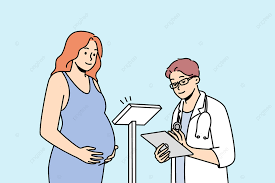 >

Importamos librerías 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
plt.rcParams['figure.figsize'] = (16, 9)
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import VotingClassifier

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import f1_score
from numpy import mean

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
RANDOM_SEED = 42

Iniciamos cargando la base de datos.

In [7]:
df = pd.read_csv(r'Maternal.csv')

Mostramos el tipo de dato que tiene los atributos. También observamos que no hay datos faltantes, por lo que todos los atributos poseen su información completa.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


#### Limpieza de datos

Desplegamos una gráfica de violín para visualizar las edades de las mujeres embarazadas.

Notamos que existe una cola que va de los 50 años hasta los 70. Sabemos además que es poco probable que una mujer en ese rando de edad se capaz de concebir un producto sano y funcional, por lo que modificamos esos valores para ahora cargar los datos en el rango de 22 a 35 que es la edad óptima para que una mujer se pueda embarazar de manera segura. 

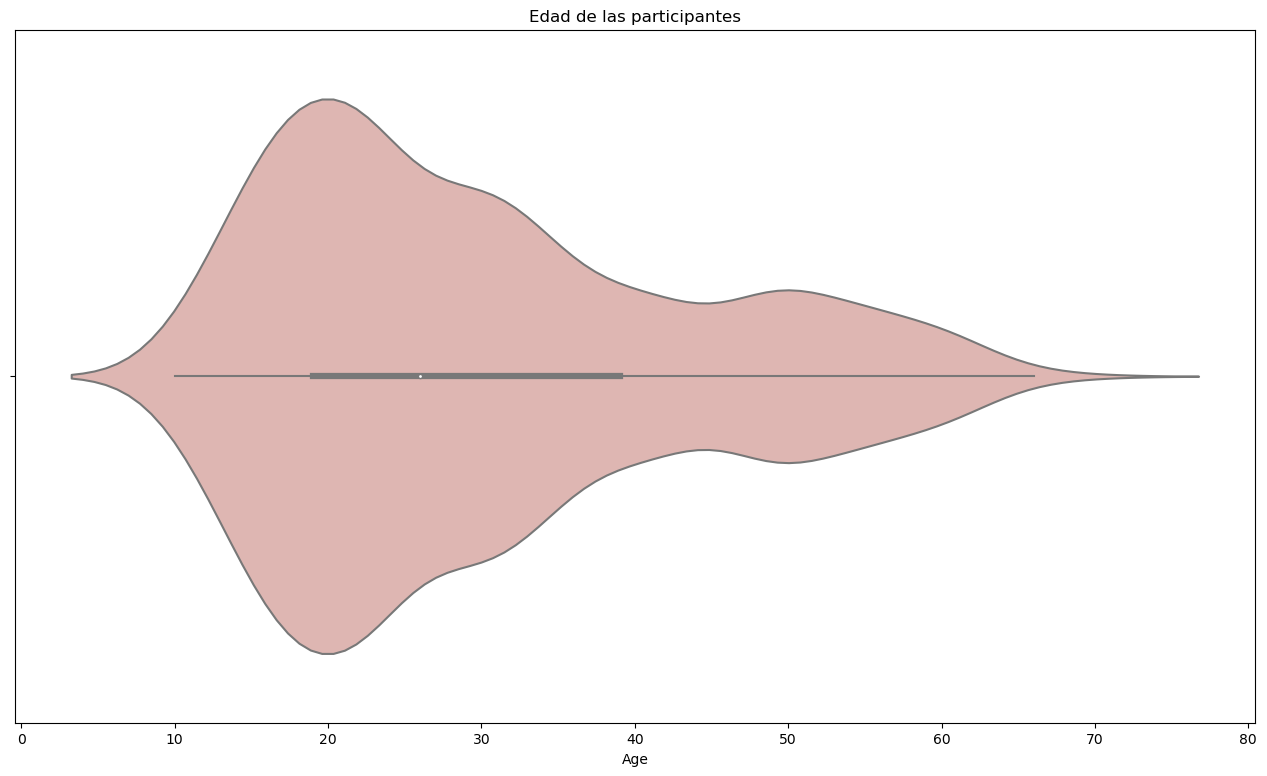

In [9]:
x=np.arange(len(df['Age']))
sns.violinplot(x=df["Age"], color='#E6B0AA');
plt.title("Edad de las participantes");

En la gráfica se puede observar que se han eliminado los vales de 50 a 70 y se han sustituido por valores entre 22 y 35. Esto se debe a que la edad de 22 a 35 años es más probable para que una mujer se embarace. Por otro lado, el embarazo después de los 50 años es poco probable y peligroso. A medida que las mujeres envejecen, su fertilidad disminuye y aumenta el riesgo de complicaciones durante el embarazo, como la diabetes gestacional, la hipertensión arterial y la preeclampsia.

In [10]:
df['Age'] = df['Age'].replace({70 : 29})
df['Age'] = df['Age'].replace({66 : 29})
df['Age'] = df['Age'].replace({65 : 22})
df['Age'] = df['Age'].replace({63 : 22})
df['Age'] = df['Age'].replace({62 : 32})
df['Age'] = df['Age'].replace({60 : 32})
df['Age'] = df['Age'].replace({59 : 28})
df['Age'] = df['Age'].replace({56 : 28})
df['Age'] = df['Age'].replace({55 : 35})
df['Age'] = df['Age'].replace({54 : 35})
df['Age'] = df['Age'].replace({51 : 34})
df['Age'] = df['Age'].replace({50 : 34})

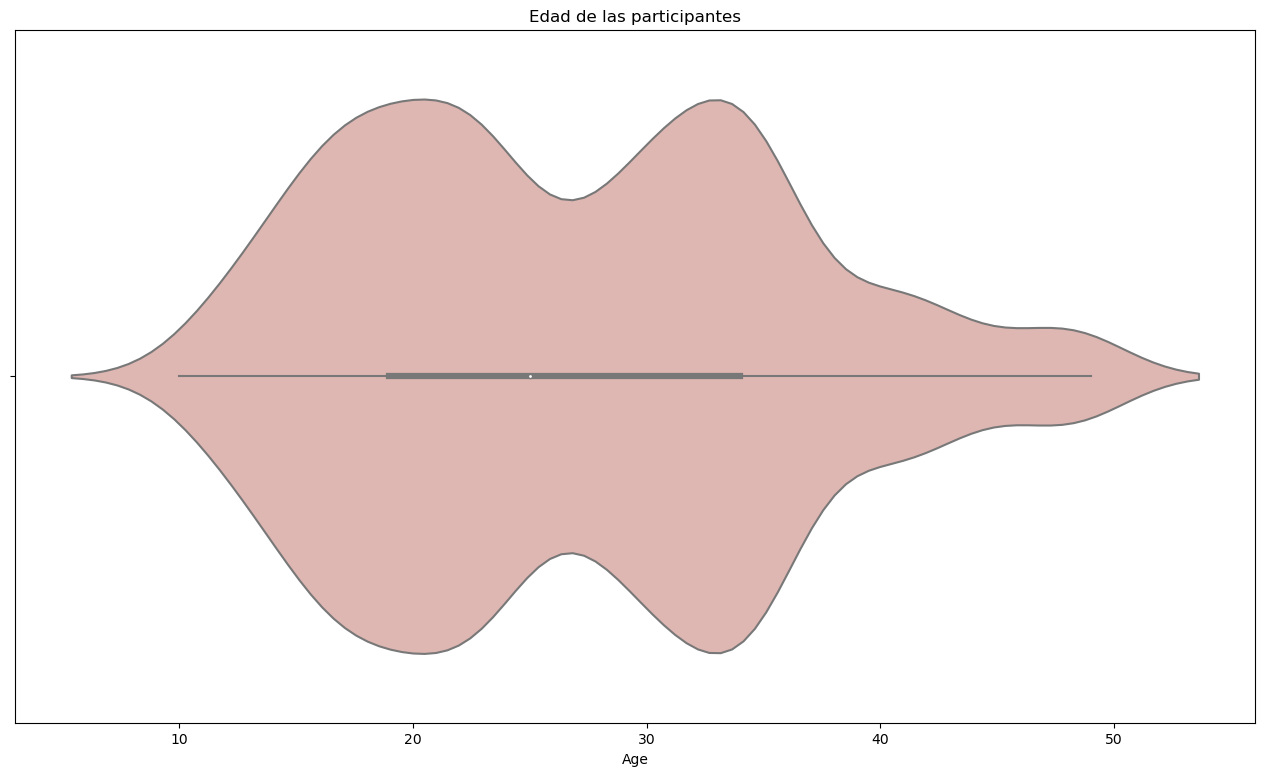

In [11]:
x=np.arange(len(df['Age']))
sns.violinplot(x=df["Age"], color='#E6B0AA');
plt.title("Edad de las participantes");

##  Resultados previos 


En el marco de la práctica anterior, se ha decidido utilizar únicamente los tres mejores clasificadores, ÁRBOLES DE DECISIÓN, SVM, RANDOM FOREST, los cuales se destacaron por su rendimiento en términos de precisión, sensibilidad y especificidad. Además, se ha decidido incluir el algoritmo de Naive Bayes como uno de los clasificadores a utilizar para comparar con los modelos de meta aprendizaje. Al incluir este clasificador en el análisis, se busca evaluar su desempeño y compararlo con los modelos de meta aprendizaje, lo que permitirá obtener una visión más completa y precisa de los resultados obtenidos.


Definimos las variables dependientes e independientes

In [12]:
X = df[['Age', 'SystolicBP', 'DiastolicBP','BS', 'BodyTemp', 'HeartRate']]
y = df[['RiskLevel']]

La función perf_measure esta diseñada para obtener TP, FP, TN, FN de una matriz de confusión MULTICLASE, por lo que esta función solamente será mandada a llamar.

In [13]:
#Función para obtener TP, FP, TN, FN de una matriz de confusión MULTICLASE
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [14]:
#Reshape para tener la y de manera adimensional  
y = np.array(y).reshape(1014)

### 1 <font color='green'>Árboles de Decisión</font>  


Los árboles de decisión son un tipo de algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Los árboles de decisión construyen un modelo de predicción a partir de un conjunto de datos de entrenamiento. El modelo se compone de un conjunto de reglas que se pueden utilizar para predecir el valor de una variable objetivo para una nueva observación.

In [15]:
Clasificador1 = DecisionTreeClassifier(max_depth=5, random_state=80)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador1, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [16]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[365  37   4]
 [205  93  38]
 [ 24  41 207]]
Test accuracy =  0.6558185404339251


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [17]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[365, 93, 207] [229, 78, 42] [300, 572, 458] [120, 271, 307]


Se obtiene la sensibilidad y la especificidad. 

In [18]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [19]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.48789435069699194 
Specificity:  0.7921381774865992


### 2 <font color='#B04ECB'>Máquinas de soporte vectorial (SVM)</font> 

In [20]:
Clasificador4 = SVC(kernel="linear", C=0.025, random_state=12)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador4, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [21]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[333  63  10]
 [178 114  44]
 [ 44  58 170]]
Test accuracy =  0.6084812623274162


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [22]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[333, 114, 170] [222, 121, 54] [284, 503, 447] [175, 276, 343]


Se obtiene la sensibilidad y la especificidad. 

In [23]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [24]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.4372785258681786 
Specificity:  0.756591048436542


### 3 <font color='#5B6FDF '>Random Forest</font>


Random Forest es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Random Forest es un conjunto de árboles de decisión aleatorios.
Random Forest funciona construyendo un conjunto de árboles de decisión aleatorios. Cada árbol de decisión se construye sobre un subconjunto aleatorio de los datos de entrenamiento. Las observaciones que se utilizan para construir un árbol de decisión son seleccionadas al azar sin reemplazo.

In [25]:
Clasificador7 = RandomForestClassifier(max_depth=6, n_estimators=15, max_features=3, random_state=42)
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador7, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [26]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[318  82   6]
 [191  96  49]
 [ 25  44 203]]
Test accuracy =  0.6084812623274162


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [27]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[318, 96, 203] [216, 126, 55] [299, 521, 414] [181, 271, 342]


Se obtiene la sensibilidad y la especificidad. 

In [28]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [29]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.4372785258681786 
Specificity:  0.756591048436542


### 4 <font color='#EE8983 '>Aprendizaje Bayesiano</font>

El aprendizaje bayesiano es un enfoque de aprendizaje automático que utiliza la teoría de la probabilidad bayesiana para hacer inferencias sobre los datos. La teoría de la probabilidad bayesiana se basa en la idea de que la probabilidad de un evento depende de la información previa que se tiene sobre ese evento.

In [30]:
Clasificador2 = GaussianNB()
#Aquí se genera la predicción sobre los datos
y_pred = cross_val_predict(Clasificador2, X, y, cv=10)

Generamos la matriz de consfusión así como su accuracy

In [31]:
#Matriz de confusión
cm = confusion_matrix(y, y_pred) 
print ("Matriz de Confusión : \n", cm) 
  
# accuracy 
print('Test accuracy = ', accuracy_score(y, y_pred))

Matriz de Confusión : 
 [[346  36  24]
 [256  44  36]
 [ 43  54 175]]
Test accuracy =  0.5571992110453649


Obtenemos los TrueNegative TruePositive, FalsePositive, FalseNegative, así como la sensibilidad y la especificidad. 

In [32]:
#Se manda a llamar la funcion perf_measure para obtener los valores de TP, FP, TN, FN
ci, TP, FP, TN, FN = perf_measure(y, y_pred)
print(TP, FP, TN, FN)

[346, 44, 175] [299, 90, 60] [219, 521, 390] [150, 359, 389]


Se obtiene la sensibilidad y la especificidad. 

In [33]:
# Sensitivity
TPR = sum(TP)/sum((TP+FN))
# Specificity or true negative rate
TNR = sum(TN)/sum((TN+FP)) 


In [34]:
print("Sensitivity: ", TPR, "\nSpecificity: ", TNR)

Sensitivity:  0.38619275461380725 
Specificity:  0.7156428119062698


###  <font color='#6B6FBF '>Tabla de clasificadores y sus resultados respectivos. </font>
| Clasificador | Accuracy | Sensitivity |Specificity|
|----------|----------|----------|--------|
| Árbol de desición| [0.64](dot.com) | [0.48](dot.com)  |[0.78](dot.com)  |
| SVM     | 0.60 | 0.43 | 0.75 |
| Random Forest | 0.61 | 0.44| 0.76|
| Aprendizaje Bayesiano   | 0.54   | 0.37   | 0.70  |

#  <font color='#EC7063 '> 1er Objetivo  </font>

###  <font color='#FC7068 '> Baseline model  </font>

X = preprocessing.StandardScaler().fit(X).transform(X) realiza una transformación de los datos en la variable `X` utilizando el método `StandardScaler` del módulo `preprocessing` de la biblioteca de Python. 

El método `StandardScaler` se utiliza para estandarizar los datos, lo que implica restar la media y dividir por la desviación estándar de cada característica. Esto es útil para asegurarse de que todas las características tengan la misma escala y para evitar que características con valores más altos dominen el modelo.



In [35]:
X = preprocessing.StandardScaler().fit(X).transform(X)

In [36]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [37]:
clf_nb = GaussianNB()
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_nb.fit(X_train, y_train)
    y_pred = clf_nb.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted')) #Promedio pesado 

print(scores)
print(mean(scores))

[0.5485952463163533, 0.5739504746958964, 0.5879870066493951, 0.5889913635207945, 0.5851010354880868]
0.5769250253341053


## <font color='#FC7068 '> Metamodelos Heterogéneos </font>

### <font color='#FC7068 '> Boosting  </font>

Boosting es un meta-algoritmo de aprendizaje automático que combina modelos débiles de forma secuencial para crear un modelo final más fuerte y preciso. Se utiliza para reducir el sesgo y la varianza en el aprendizaje supervisado.

In [38]:
clf = GradientBoostingClassifier(n_estimators=10)
scores = cross_val_score(clf, X, y,  cv=10)
print(scores)
print(scores.mean())

[0.48039216 0.56862745 0.42156863 0.55882353 0.76237624 0.68316832
 0.8019802  0.55445545 0.64356436 0.66336634]
0.613832265579499


###  <font color='#FC7068 '> Bagging  </font>

Bagging, también conocido como Bootstrap Aggregating, es un método de aprendizaje automático que se utiliza para mejorar la precisión y estabilidad de los modelos predictivos. El objetivo del bagging es reducir la varianza y el sobreajuste en los modelos.
Es importante destacar que el bagging se utiliza principalmente con modelos que son propensos al sobreajuste, como los árboles de decisión. Al generar múltiples conjuntos de datos de entrenamiento y modelos base independientes, el bagging ayuda a reducir la varianza y mejorar el rendimiento del modelo.




In [39]:
clf = BaggingClassifier(n_estimators=10)
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())

[0.5        0.65686275 0.39215686 0.58823529 0.58415842 0.65346535
 0.57425743 0.51485149 0.62376238 0.64356436]
0.5731314307901378


###  <font color='#FC7068 '> Voting  </font>

Es un método de combinación de los resultados de diferentes modelos de aprendizaje automático para mejorar la precisión de las predicciones. 

Hay dos tipos principales de voting:Hard voting: Cada modelo de aprendizaje automático vota por la clase o valor que cree que es el más probable. El resultado final es la clase o valor con la mayoría de los votos.
Soft voting: Cada modelo de aprendizaje automático asigna una probabilidad a cada clase o valor. El resultado final es la clase o valor con la probabilidad más alta.


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [41]:
clf1 = DecisionTreeClassifier()
clf2 = GaussianNB()
clf3 = KNeighborsClassifier(n_neighbors=3)
clf4 = svm.SVC()

In [42]:
eclf = VotingClassifier(
     estimators=[('dt', clf1), ('nb', clf2), ('kNN', clf3), ('svm', clf4)],
     voting='hard') # 'soft' Hard usa la mayoria y no toma en cuenta kas probabilidades 

In [43]:
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['dt', 'nb', 'kNN', 'svm', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.59 (+/- 0.06) [dt]
Accuracy: 0.56 (+/- 0.13) [nb]
Accuracy: 0.47 (+/- 0.07) [kNN]
Accuracy: 0.61 (+/- 0.12) [svm]
Accuracy: 0.60 (+/- 0.13) [Ensemble]


## <font color='#FC7068 '> Metamodelos Homogéneos  </font>

### <font color='#FC7068 '> Deep tree  </font>
Los metamodelos deep tree son una extensión de los árboles de decisión tradicionales. En lugar de utilizar un solo árbol de decisión, los metamodelos deep tree utilizan un conjunto de árboles de decisión, cada uno de los cuales se especializa en aprender un aspecto diferente de la función de predicción.

Los metamodelos deep tree tienen varias ventajas sobre los árboles de decisión tradicionales. En primer lugar, son capaces de aprender funciones más complejas que los árboles de decisión tradicionales. En segundo lugar, son más robustos a los datos ruidosos. En tercer lugar, son más fáciles de entrenar y ajustar.

In [44]:
clf_ddt = DecisionTreeClassifier()
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_ddt.fit(X_train, y_train)
    y_pred = clf_ddt.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.8674870331274271, 0.8475070608005656, 0.8433409287419783, 0.8358391254470612, 0.8015493963298479]
0.8391447088893761


### <font color='#FC7068 '> Shallow tree  </font>

Utiliza un conjunto de árboles de decisión de poca profundidad para aprender una función de predicción. 
En lugar de utilizar un solo árbol de decisión, este utiliza un conjunto de árboles de decisión, cada uno de los cuales se especializa en aprender un aspecto diferente de la función de predicción.

Los metamodelos shallow tree tienen varias ventajas sobre los árboles de decisión tradicionales. En primer lugar, son más fáciles de entrenar y ajustar. En segundo lugar, son menos propensos a sobreajustar los datos. En tercer lugar, pueden ser más robustos a los datos ruidosos.

In [45]:
#Aca si se restinge en profundidad
clf_sdt = DecisionTreeClassifier(max_depth=2)
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_sdt.fit(X_train, y_train)
    y_pred = clf_sdt.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.5029086222195024, 0.5051210291195318, 0.49289569714501813, 0.5145160317574111, 0.5106150297109439]
0.5052112819904815


### <font color='#FC7068 '> Adaboost </font>

AdaBoost (Adaptive Boosting) es un algoritmo de aprendizaje automático supervisado que se utiliza para mejorar la precisión de los clasificadores débiles. El algoritmo de AdaBoost entrena iterativamente una secuencia de clasificadores débiles en diferentes subconjuntos de datos, asignando mayores pesos a los datos que se clasificaron incorrectamente en iteraciones anteriores. El clasificador final de AdaBoost es la combinación de los clasificadores débiles entrenados.

AdaBoost tiene varias ventajas sobre los clasificadores débiles individuales. En primer lugar, AdaBoost puede mejorar el rendimiento de los clasificadores débiles. En segundo lugar, AdaBoost es robusto a los datos ruidosos. En tercer lugar, AdaBoost es relativamente fácil de implementar.

In [46]:
clf_ab = AdaBoostClassifier(n_estimators=5, random_state=0)
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_ab.fit(X_train, y_train)
    y_pred = clf_ab.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.5763236042635178, 0.6814520710833059, 0.6777020085598847, 0.694392896396575, 0.6497067093415965]
0.6559154579289759


###  <font color='#FC7068 '> Random Forest  </font>

Random Forest es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y la regresión. Random Forest es un conjunto de árboles de decisión aleatorios. Random Forest funciona construyendo un conjunto de árboles de decisión aleatorios. Cada árbol de decisión se construye sobre un subconjunto aleatorio de los datos de entrenamiento. Las observaciones que se utilizan para construir un árbol de decisión son seleccionadas al azar sin reemplazo.

In [47]:
clf_rf = RandomForestClassifier(n_estimators=10, random_state=0)
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.8439167754516358, 0.8267753484766575, 0.8719889488362395, 0.8264579059466098, 0.7914710403670028]
0.8321220038156291


###  <font color='#6B6FBF '>Resultados con metamodelos </font>
Meta-Modelos | Precision|
|------------|----------|
| <font color='red'>Naive-Bayes </font> |<font color='red'>0.57 </font>  |
| Boosting    | 0.61   |
| Baging     | 0.57 |
| Voting  | 0.59 |
|[DeepTree](dot.com) | [0.83](dot.com) |
|ShallowTree | 0.50 |
|[Adaboost](dot.com) | [0.65](dot.com) |
|[Random Forest](dot.com) | [0.83](dot.com ) |

Se decidió utilizar únicamente los tres mejores modelos para nuestro análisis. Estos modelos son Random Forest, Deep Tree y Adaboost. Durante las pruebas, todos los metamodelos a excepción de Shallow Tree, demostraron ser superiores al modelo base, que en este caso es Naive Bayes. Estos tres modelos han demostrado su capacidad para realizar predicciones más precisas y obtener resultados más sólidos en comparación con el modelo base. 


# <font color='#9B59B6'> 2do Objetivo  </font>

A continuación, se presenta la tabla 2 donde se muestran los metamodelos que se van a emplear para realizar la optimación de sus parámetros.

###  <font color='#9B59B6'>Resultados con metamodelos </font>
Meta-Modelos | Precision|
|------------|----------|
|[DeepTree](dot.com) | [0.83](dot.com) |
|[Adaboost](dot.com) | [0.65](dot.com) |
|[Random Forest](dot.com) | [0.83](dot.com ) |

### <font color='#9B59B6'> Deep tree  </font>


In [48]:
clf_ddt = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=1000, max_features='log2' )
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_ddt.fit(X_train, y_train)
    y_pred = clf_ddt.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.8470261151224779, 0.8523688785859171, 0.84126409526931, 0.8763995599179704, 0.8167119733324647]
0.846754124445628


### <font color='#9B59B6 '> Adaboost </font>

In [49]:
clf_ab = AdaBoostClassifier(n_estimators=15, random_state=0)
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_ab.fit(X_train, y_train)
    y_pred = clf_ab.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.5613916816213226, 0.7286050637853805, 0.6659159785986204, 0.7311736089250983, 0.679493976326772]
0.6733160618514388


###  <font color='#9B59B6 '> Random Forest  </font>


In [50]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0,
        criterion='log_loss', max_depth=35, min_samples_split=2,  max_features='sqrt', 
        class_weight='balanced_subsample')
scores = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.8632989620029657, 0.8364599950768415, 0.8571428571428571, 0.856201016070103, 0.821599260202073]
0.8469404180989681


##  <font color='#9B59B6'>Discusión y Resultados con metamodelos optimizados y no optimizados</font>

A continuación  se presenta la tabla 3 en donde se muestran las precisiones obtenidas con los parametros optimizados y no optimizados
Meta-Modelos | Precision|
|------------|----------|
|[DeepTree](dot.com) | [0.83](dot.com) |
|[Adaboost](dot.com) | [0.65](dot.com) |
|[Random Forest](dot.com) | [0.83](dot.com ) |
|<font color='green'>Meta-Modelos</font>| <font color='green'>Optimizados</font> |
|DeepTree | 0.83|
|Adaboost| 0.67|
|RandomForest | 0.84|


Se evaluó el rendimiento de varios ensambles de modelos de aprendizaje automático para un problema de clasificación. Los ensambles utilizados fueron: Naive-Bayes, Boosting, Bagging, Voting, DeepTree, ShallowTree, Adaboost, Random Forest
Los resultados mostraron que los tres mejores ensambles fueron DeepTree, Adaboost y Random Forest. Estos ensambles obtuvieron una precisión significativamente mayor que el modelo base, Naive Bayes.

Los resultados sugieren que los ensambles pueden ser una opción superior a los modelos individuales para problemas de clasificación. Ya que en la práctica anteior se obtuvo una mala clasificación, y el clasificador que obtuvo la mejor clasificación fue Arbol de decisión con un accuracy de 0.65. 

En particular, el ensamble DeepTree se destacó por su precisión. Esto se debe a que DeepTree utiliza un conjunto de árboles de decisión de profundidad variable para aprender una función de predicción. Esto permite a DeepTree aprender funciones más complejas que los árboles de decisión individuales.

El ensamble Adaboost también se destacó por su precisión. Esto se debe a que Adaboost utiliza un conjunto de clasificadores débiles para aprender una función de predicción. Adaboost es capaz de mejorar el rendimiento de los clasificadores débiles al asignar mayores pesos a los datos que se clasifican incorrectamente.

El ensamble Random Forest también se destacó por su precisión. Esto se debe a que Random Forest utiliza un conjunto de árboles de decisión aleatorios para aprender una función de predicción. Random Forest es capaz de aprender funciones más complejas que los árboles de decisión individuales y es más robusto a los datos ruidosos.

Finalmente, los resultados de este estudio mostraron que no se mostraron mejoras significativas al optimizar los parámetros de los ensambles. Esto sugiere que los parámetros predeterminados de los ensambles son adecuados para la mayoría de los problemas de clasificación.